In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_header()
results_file = '../results/spage2vec_27.h5ad'

# Load data

In [4]:
adata = sc.read(results_file)
df = pd.read_csv('../results/spage2vec_27.csv')
adata.obs.spotX=df.spotX.values
adata.obs.spotY=df.spotY.values
adata.obs["celltype_id"]=df.cell_type_id.values

# PCW 4 - clustering analysis

In [8]:
# Clustering
adata_4 = adata[adata.obs.pcw==4].copy()
sc.pp.neighbors(adata_4, metric='euclidean', n_neighbors=15)
sc.tl.leiden(adata_4, resolution=1, random_state = 42)
# save anndata
adata_4.write('../results/anndata_pcw4.h5')

/home/gabriele/miniconda3/envs/spage2vec/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:06)
running Leiden clustering
    finished: found 101 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:03:11)


In [8]:
# Load clustering data
adata_4 = sc.read('../results/anndata_pcw4.h5')

#### Compute Paga graph

In [9]:
sc.tl.paga(adata_4, groups='leiden', use_rna_velocity=False, model='v1.2')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:01:04)


--> added 'pos', the PAGA positions (adata.uns['paga'])


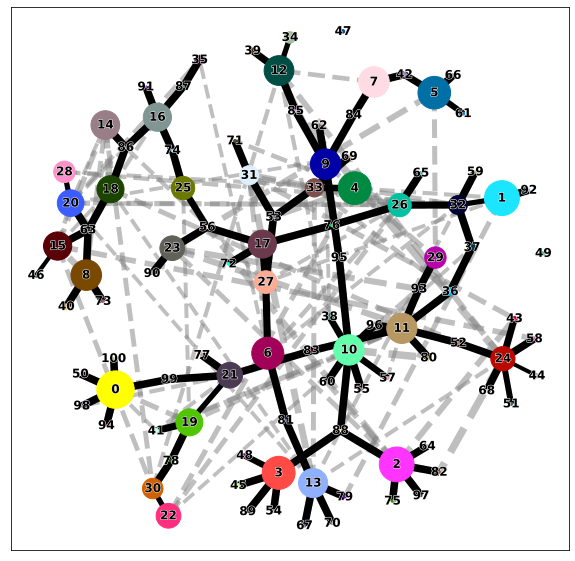

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sc.pl.paga(adata_4,
    threshold=0.5,           
    solid_edges='connectivities_tree',
    dashed_edges='connectivities', 
    node_size_scale=0.1,
    node_size_power=0.8,
    fontsize=12,
    fontoutline=1,
    ax=ax)

#### Merge clusters with less the <em>n</em> reads to a bigger cluster based on <em>connectivities_tree</em>

In [14]:
n = 1000
min_connectivity = 0.1
c_counts = adata_4.obs.leiden.value_counts()
c_tomerge = c_counts[c_counts < n].index.values

d_merge = {}
for c in c_counts.index.values:
    if c in c_tomerge:
        c_conn = adata_4.uns['paga']['connectivities'].toarray()[int(c),:]
        if c_conn.max() > min_connectivity:
            d_merge[c] = str(np.argmax(c_conn))
        else:
            d_merge[c] = str(-1)
    else:
        d_merge[c] = c

d_merge['-1'] = str(-1)
print("N cluster removed: " + str(np.unique(list(d_merge.values()), return_counts=True)[1][0]))

N cluster removed: 1


In [15]:
adata_4.obs['leiden_m1'] = adata_4.obs.leiden.map(d_merge)

while len(list(set(adata_4.obs.leiden_m1.unique()) & set(c_tomerge)))>0:
    adata_4.obs['leiden_m1'] = adata_4.obs.leiden_m1.map(d_merge)

In [17]:
adata_4 = adata_4[adata_4.obs_vector('leiden_m1')!='-1'].copy()

/home/gabriele/miniconda3/envs/spage2vec/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [19]:
# save csv
adata_4.obs.to_csv("../results/pcw_4.csv", index=False)

#### Plot cluster expression profiles

In [20]:
# Create cluster gene expression matrix
hm = adata_4.obs.groupby(['gene','leiden_m1']).size().unstack(fill_value=0)
hm.shape

(65, 34)

In [21]:
# Z-score normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hm = pd.DataFrame(scaler.fit_transform(hm.values), columns=hm.columns, index=hm.index)
hm.head()

leiden_m1,0,1,10,11,12,13,14,15,16,17,...,30,31,32,33,4,5,6,7,8,9
gene,,,,,,,,,,,,,,,,,,,,,
ALDH1A1,-0.488630,-0.439211,-0.544177,-0.582685,-0.395752,-0.272558,-0.407739,-0.393256,-0.572721,-0.572472,...,-0.481592,-0.383099,-0.443642,-0.414688,-0.516210,-0.359658,-0.393453,-0.334314,-0.378955,-0.256175
CCDC102B,-0.488630,-0.429656,-0.499845,-0.552886,-0.391868,-0.269451,-0.373879,-0.393256,-0.491380,-0.572472,...,-0.468323,-0.358493,-0.443642,-0.414688,-0.511817,-0.353481,-0.375658,-0.334314,-0.371406,-0.258812
CDK1,-0.366850,-0.394623,-0.461055,-0.415810,-0.314188,-0.257026,-0.364204,-0.320527,-0.410040,-0.436693,...,0.089010,-0.321583,-0.314843,-0.354689,-0.340468,-0.322595,-0.329392,-0.311090,-0.314790,-0.235077
CLDN5,-0.476749,-0.416917,-0.544177,-0.570765,-0.395752,-0.272558,-0.407739,-0.388407,-0.552386,-0.558180,...,-0.481592,-0.370796,-0.443642,-0.384688,-0.498636,-0.359658,-0.389894,-0.330996,-0.378955,-0.258812
CLU,-0.360909,-0.426471,-0.544177,-0.600564,-0.395752,-0.266345,-0.402902,-0.369013,-0.559164,-0.543887,...,-0.468323,-0.370796,-0.443642,-0.384688,-0.485455,-0.356569,-0.393453,-0.334314,-0.378955,-0.256175


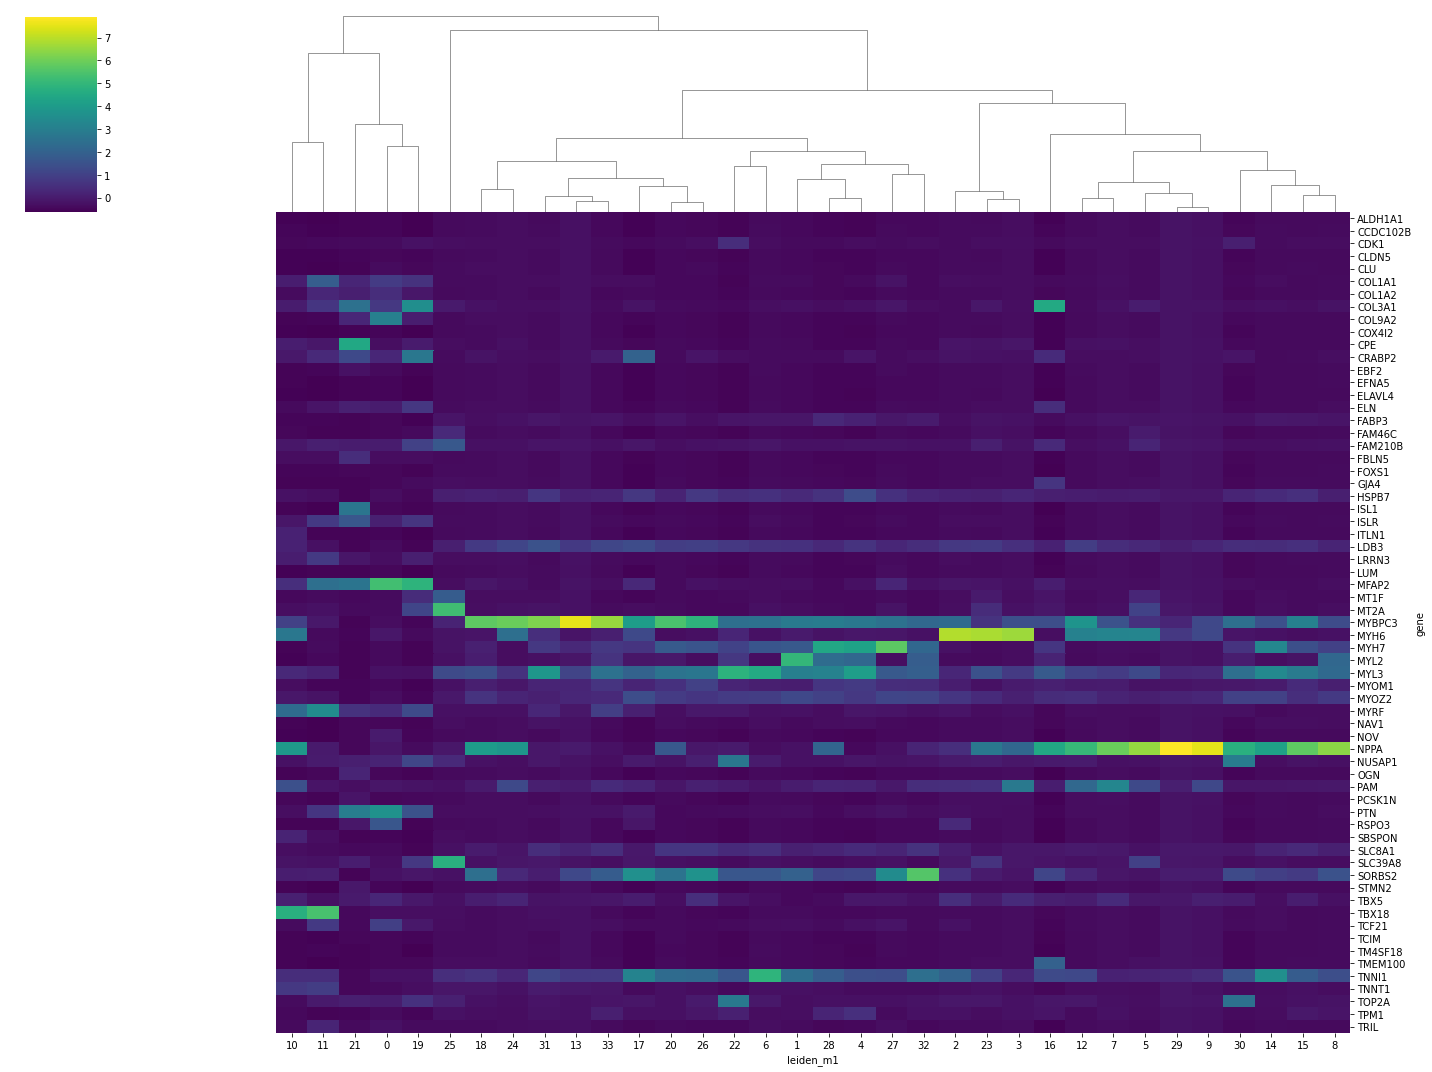

In [22]:
import seaborn as sns
g = sns.clustermap(hm, row_cluster=False, metric='correlation', method='average', cmap='viridis', figsize=(20,15), xticklabels=True, yticklabels=True)

# PCW 6.5 - clustering analysis

In [8]:
# Clustering
adata_6 = adata[adata.obs.pcw==6].copy()
sc.pp.neighbors(adata_6, metric='euclidean', n_neighbors=15)
sc.tl.leiden(adata_6, resolution=1, random_state = 42)
# save anndata
adata_6.write('../results/anndata_pcw6.h5')

/home/gabriele/miniconda3/envs/spage2vec/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:55)
running Leiden clustering
    finished: found 123 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:46:29)


In [29]:
# Load clustering data
adata_6 = sc.read('../results/anndata_pcw6.h5')

#### Compute Paga graph

In [30]:
sc.tl.paga(adata_6, groups='leiden', use_rna_velocity=False, model='v1.2', neighbors_key=None, copy=False)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:05:45)


the obs value 'leiden' has more than 103 categories. Uniform 'grey' color will be used for all categories.
--> added 'pos', the PAGA positions (adata.uns['paga'])


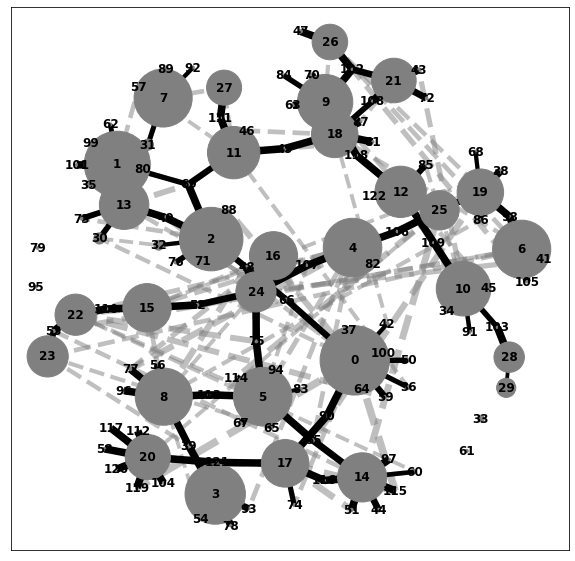

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
sc.pl.paga(adata_6,
    threshold=0.5,           
    solid_edges='connectivities_tree',
    dashed_edges='connectivities', 
    node_size_scale=0.1,
    node_size_power=0.8,
    fontsize=12,
    ax=ax)

#### Merge clusters with less the <em>n</em> reads to a bigger cluster based on <em>connectivities_tree</em>

In [34]:
n = 1000
min_connectivity = 0.1
c_counts = adata_6.obs.leiden.value_counts()
c_tomerge = c_counts[c_counts < n].index.values

d_merge = {}
for c in c_counts.index.values:
    if c in c_tomerge:
        c_conn = adata_6.uns['paga']['connectivities'].toarray()[int(c),:]
        if c_conn.max() > min_connectivity:
            d_merge[c] = str(np.argmax(c_conn))
        else:
            d_merge[c] = str(-1)
    else:
        d_merge[c] = c

d_merge['-1'] = str(-1)
print("N cluster removed: " + str(np.unique(list(d_merge.values()), return_counts=True)[1][0]))

N cluster removed: 2


In [35]:
adata_6.obs['leiden_m1'] = adata_6.obs.leiden.map(d_merge)

while len(list(set(adata_6.obs.leiden_m1.unique()) & set(c_tomerge)))>0:
    adata_6.obs['leiden_m1'] = adata_6.obs.leiden_m1.map(d_merge)

In [37]:
adata_6 = adata_6[adata_6.obs_vector('leiden_m1')!='-1'].copy()
adata_6.shape

/home/gabriele/miniconda3/envs/spage2vec/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(795933, 32)

In [38]:
# save csv
adata_6.obs.to_csv("../results/pcw_6.csv", index=False)

#### Plot cluster expression profiles

In [39]:
# Create cluster gene expression matrix
hm = adata_6.obs.groupby(['gene','leiden_m1']).size().unstack(fill_value=0)
hm.shape

(67, 30)

In [40]:
# Z-score normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hm = pd.DataFrame(scaler.fit_transform(hm.values), columns=hm.columns, index=hm.index)
hm.head()

leiden_m1,0,1,10,11,12,13,14,15,16,17,...,27,28,29,3,4,5,6,7,8,9
gene,,,,,,,,,,,,,,,,,,,,,
ALDH1A1,-0.289703,-0.337631,-0.372619,-0.477289,-0.430651,-0.325694,-0.675329,-0.556918,-0.454347,-0.492826,...,-0.426122,-0.097825,1.243335,-0.484115,-0.516561,-0.432952,-0.701153,-0.338186,-0.506268,-0.318490
CCDC102B,-0.287025,-0.334064,-0.412037,-0.389074,-0.418117,-0.326577,-0.458613,-0.529915,-0.374179,-0.429224,...,-0.340974,-0.280588,-0.317190,-0.453157,-0.491857,-0.406922,-0.380658,-0.340044,-0.491008,-0.246768
CDK1,-0.241171,-0.233729,-0.261263,-0.346780,-0.247204,-0.286845,-0.398829,0.526383,-0.393893,-0.327167,...,-0.340974,-0.160846,-0.007467,-0.326148,-0.294224,-0.317349,-0.381925,-0.254589,-0.267832,-0.267959
CLDN5,-0.287695,-0.333618,-0.452440,-0.483331,-0.413560,-0.321279,-0.568839,-0.533092,-0.433319,-0.472118,...,-0.511270,-0.315249,-0.412489,-0.460301,-0.512901,-0.430655,-0.604878,-0.336328,-0.490054,-0.316045
CLU,-0.289703,-0.338523,-0.456382,-0.511125,-0.407862,-0.333640,-0.632360,-0.542622,-0.443833,-0.479514,...,-0.656022,-0.308947,-0.376752,-0.458714,-0.505581,-0.406922,-0.677084,-0.347474,-0.489100,-0.387767


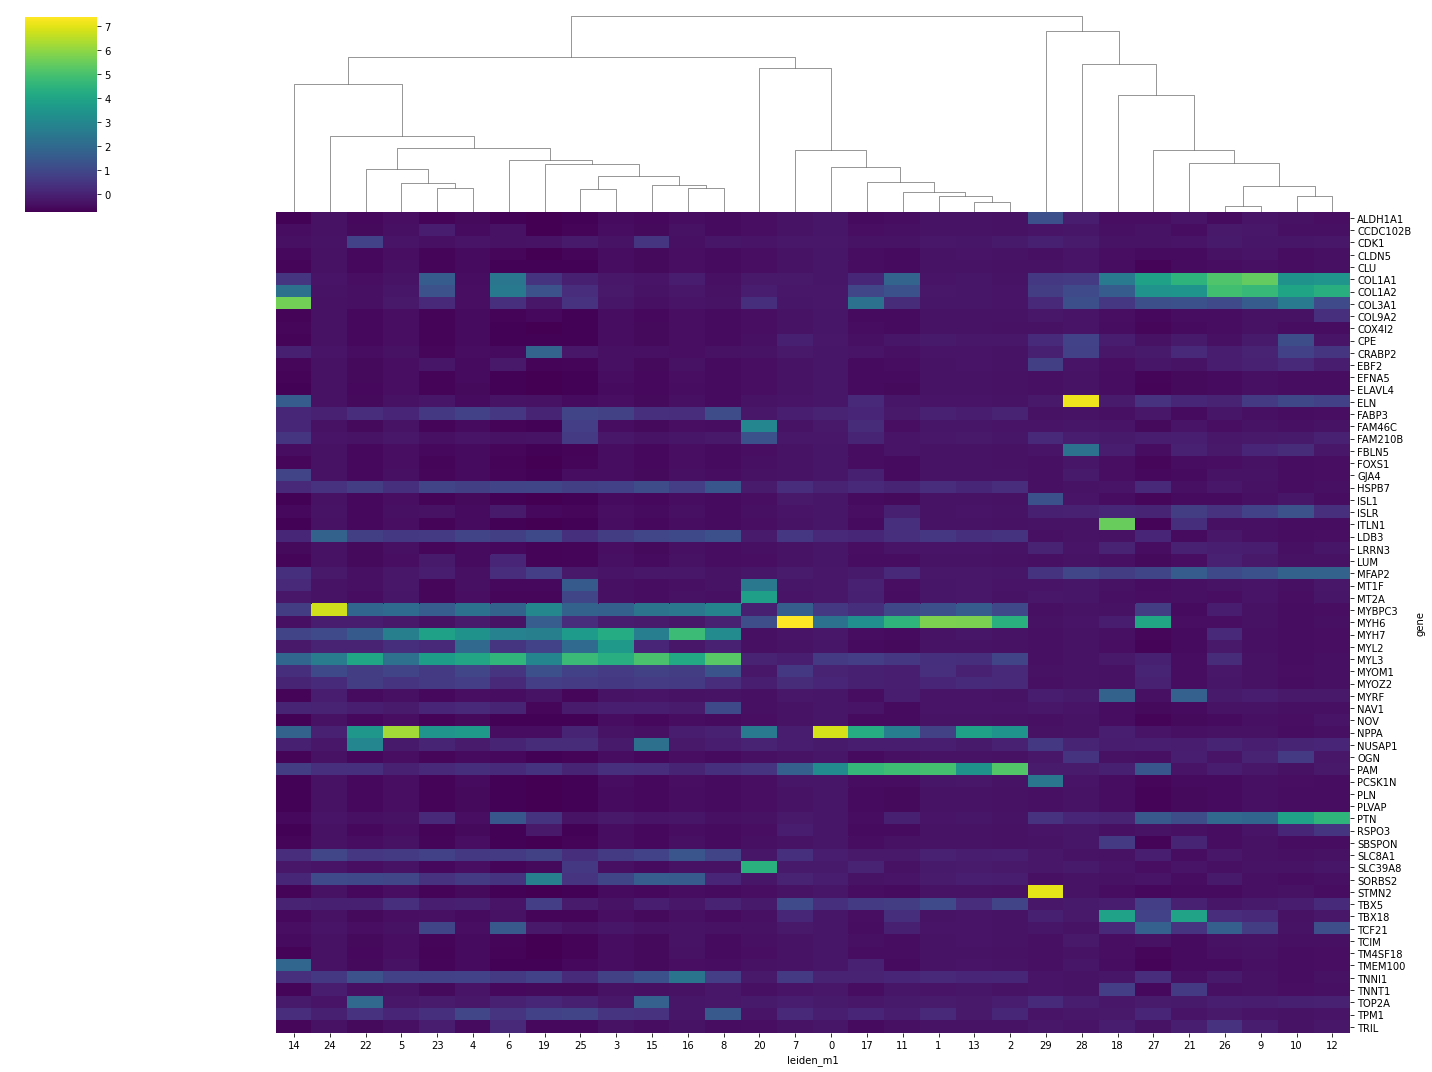

In [41]:
import seaborn as sns
g = sns.clustermap(hm, row_cluster=False, metric='correlation', method='average', cmap='viridis', figsize=(20,15), xticklabels=True, yticklabels=True)

# PCW 9 - clustering analysis

In [30]:
# Clustering
adata_9 = adata[adata.obs.pcw==9]
sc.pp.neighbors(adata_9, metric='euclidean', n_neighbors=15)
sc.tl.leiden(adata_9, resolution=1, random_state = 42)
# save anndata
adata_9.write('../results/anndata_pcw9.h5')

/home/gabriele/miniconda3/envs/spage2vec/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:21)
running Leiden clustering
    finished: found 155 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (2:57:49)


In [48]:
# Load clustering data
adata_9 = sc.read('../results/anndata_pcw9.h5')

#### Compute Paga graph

In [49]:
sc.tl.paga(adata_9, groups='leiden', use_rna_velocity=False, model='v1.2', neighbors_key=None, copy=False)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:13:33)


the obs value 'leiden' has more than 103 categories. Uniform 'grey' color will be used for all categories.
--> added 'pos', the PAGA positions (adata.uns['paga'])


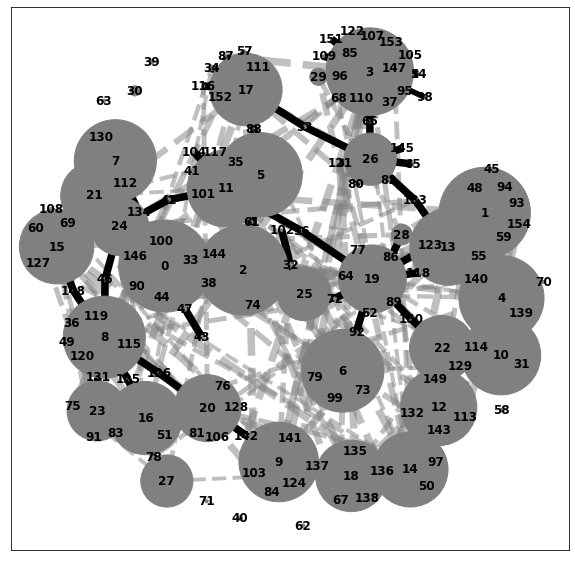

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
sc.pl.paga(adata_9,
    threshold=0.5,           
    solid_edges='connectivities_tree',
    dashed_edges='connectivities', 
    node_size_scale=0.1,
    node_size_power=0.8,
    fontsize=12,
    ax=ax)

#### Merge clusters with less the <em>n</em> reads to a bigger cluster based on <em>connectivities_tree</em>

In [53]:
n = 1000
min_connectivity = 0.1
c_counts = adata_9.obs.leiden.value_counts()
c_tomerge = c_counts[c_counts < n].index.values

d_merge = {}
for c in c_counts.index.values:
    if c in c_tomerge:
        c_conn = adata_9.uns['paga']['connectivities'].toarray()[int(c),:]
        if c_conn.max() > min_connectivity:
            d_merge[c] = str(np.argmax(c_conn))
        else:
            d_merge[c] = str(-1)
    else:
        d_merge[c] = c

d_merge['-1'] = str(-1)
print("N cluster removed: " + str(np.unique(list(d_merge.values()), return_counts=True)[1][0]))

N cluster removed: 3


In [54]:
adata_9.obs['leiden_m1'] = adata_9.obs.leiden.map(d_merge)

while len(list(set(adata_9.obs.leiden_m1.unique()) & set(c_tomerge)))>0:
    adata_9.obs['leiden_m1'] = adata_9.obs.leiden_m1.map(d_merge)
adata_9.shape

(1444243, 32)

In [55]:
adata_9 = adata_9[adata_9.obs_vector('leiden_m1')!='-1'].copy()
adata_9.shape

/home/gabriele/miniconda3/envs/spage2vec/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(1443864, 32)

In [56]:
# save csv
adata_9.obs.to_csv("../results/pcw_9.csv", index=False)

#### Plot cluster expression profiles

In [57]:
# Create cluster gene expression matrix
hm = adata_9.obs.groupby(['gene','leiden_m1']).size().unstack(fill_value=0)
hm.shape

(67, 30)

In [58]:
# Z-score normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hm = pd.DataFrame(scaler.fit_transform(hm.values), columns=hm.columns, index=hm.index)
hm.head()

leiden_m1,0,1,10,11,12,13,14,15,16,17,...,27,28,29,3,4,5,6,7,8,9
gene,,,,,,,,,,,,,,,,,,,,,
ALDH1A1,-0.154936,-0.376193,-0.483661,-0.459060,-0.367293,-0.394192,-0.556965,-0.435016,-0.296861,-0.283569,...,-0.247881,-0.183154,-0.362467,-0.340492,-0.256350,-0.225146,-0.453942,-0.216043,-0.336250,-0.566876
CCDC102B,-0.155550,-0.364032,-0.465242,-0.432436,-0.336526,-0.335013,-0.387829,-0.433746,-0.295603,-0.185738,...,-0.237261,-0.326679,-0.414693,-0.339733,-0.248428,-0.223360,-0.438892,-0.217421,-0.327365,-0.513075
CDK1,-0.149282,-0.320858,-0.425054,-0.396182,-0.327669,-0.367612,-0.451064,-0.375961,-0.227681,-0.282646,...,-0.223374,-0.362560,-0.049108,-0.337075,-0.233823,-0.204832,-0.405030,-0.204787,-0.262322,-0.406122
CLDN5,-0.155919,-0.374065,-0.478638,-0.444331,-0.363097,-0.385165,-0.492206,-0.452796,-0.296441,-0.310335,...,-0.245430,-0.350599,-0.388580,-0.373898,-0.255855,-0.225815,-0.450180,-0.217651,-0.330564,-0.537707
CLU,-0.155919,-0.368896,-0.478638,-0.452262,-0.362631,-0.392688,-0.555441,-0.464226,-0.296861,-0.321410,...,-0.248697,-0.350599,-0.388580,-0.409962,-0.247686,-0.225815,-0.444066,-0.217651,-0.335184,-0.541596


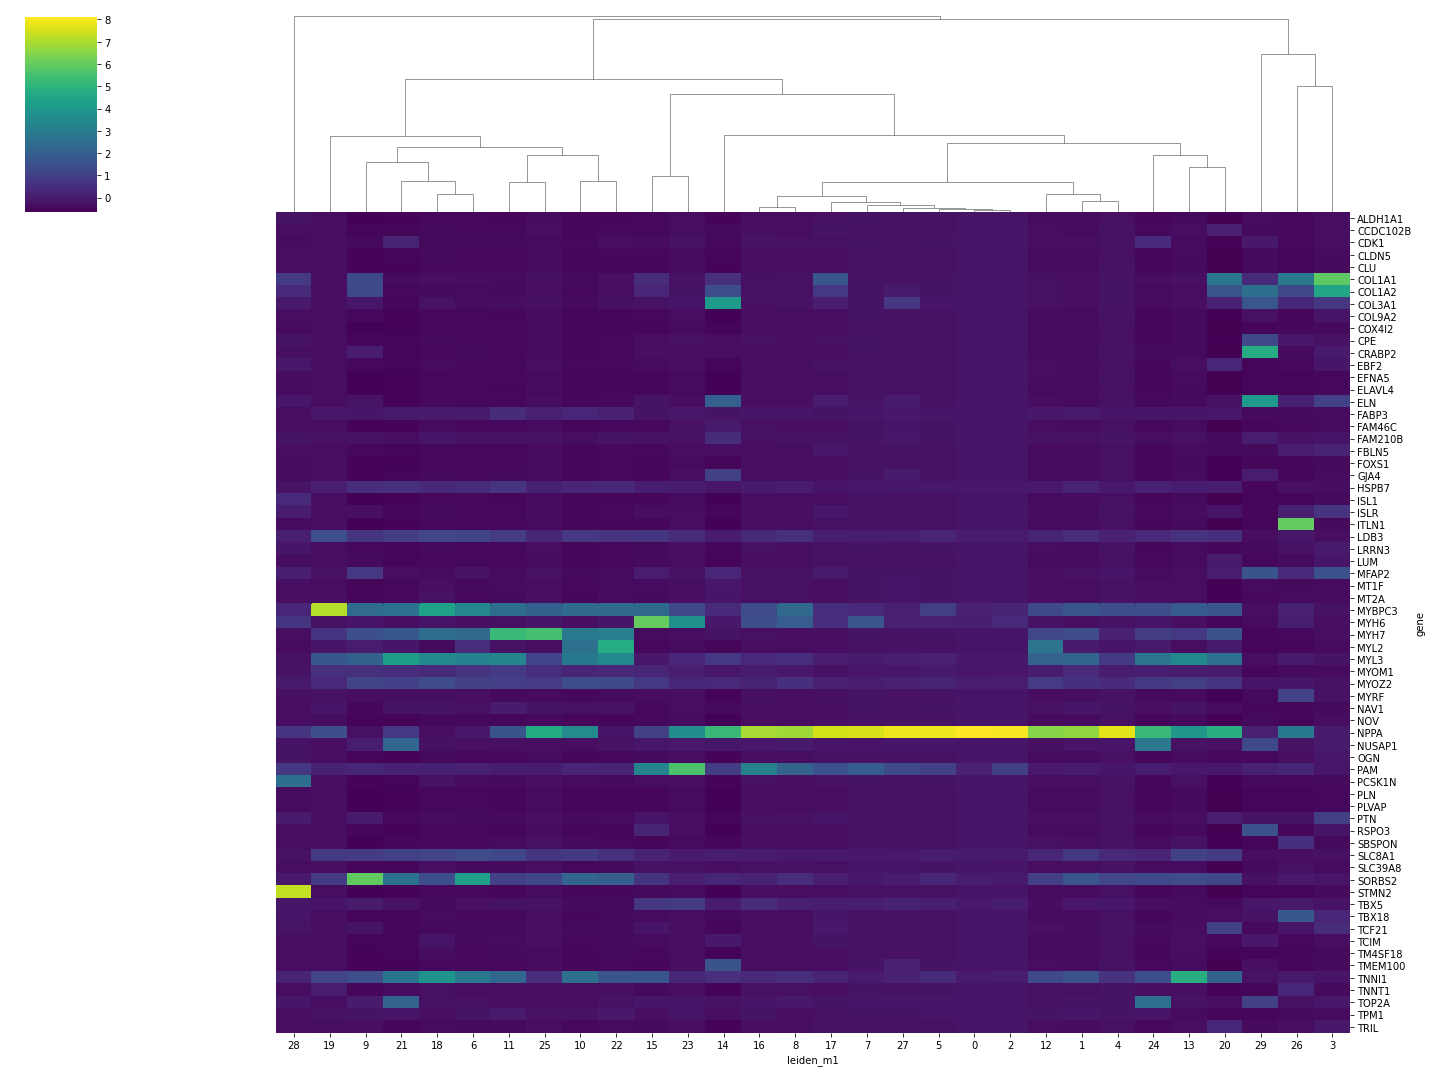

In [59]:
import seaborn as sns
g = sns.clustermap(hm, row_cluster=False, metric='correlation', method='average', cmap='viridis', figsize=(20,15), xticklabels=True, yticklabels=True)

# Integrate 4, 6.5, 9 PCW

In [66]:
adata_4.obs.leiden_m1 = adata_4.obs.leiden_m1 + '_pcw4'
adata_6.obs.leiden_m1 = adata_6.obs.leiden_m1 + '_pcw6'
adata_9.obs.leiden_m1 = adata_9.obs.leiden_m1 + '_pcw9'
adata = adata_4.concatenate(adata_6, adata_9)

In [67]:
sc.pp.neighbors(adata, metric='euclidean', n_neighbors=15)
sc.tl.paga(adata, groups='leiden_m1', use_rna_velocity=False, model='v1.2', neighbors_key=None, copy=False)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:09:01)


/home/gabriele/miniconda3/envs/spage2vec/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'gene' as categorical
... storing 'louvain' as categorical
... storing 'cell_type_id' as categorical
... storing 'leiden' as categorical
... storing 'leiden_m1' as categorical


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:14:19)


In [68]:
adata.uns['paga']['groups']

'leiden_m1'

In [69]:
adata.obs['leiden_m1_l'] = adata.obs['leiden_m1'].str.split('_', expand=True)[0]

--> added 'pos', the PAGA positions (adata.uns['paga'])


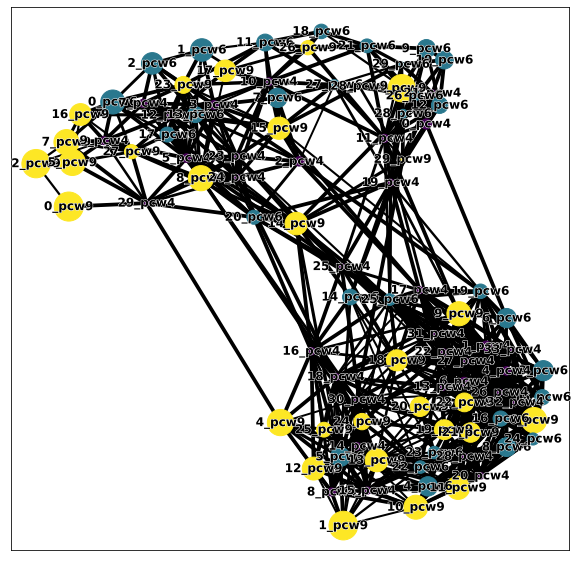

In [70]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
sc.pl.paga(adata,
    threshold=0.5,           
    solid_edges='connectivities',
    #dashed_edges='connectivities',
    layout='fa',
    node_size_scale=2,
    node_size_power=1,
    fontsize=12,
    fontoutline=1,
    color=['pcw'],
    colorbar=False,
    edge_width_scale=0.5,
    ax=ax)
fig.savefig('fa_paga.pdf')

In [71]:
adata.obs.to_csv('../results/all_pcw.csv')